# Figure 4

This notebook contains the functions used to construct Figure 4. 

The figure contains 2 panels. They show the relation between the exonic enrichment of H3K36me3 and the decreased exonic mutation burden for:

- a) Colorectal POLE-mutant tumors.
- b) Colorectal MSI-H and bMMRD tumors.

---

The data required for each panel is saved in a file and loaded before plotting. The reason is that, once the data has been generated, the plot can be created and modified without recomputing the data.

In [1]:
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import scipy.stats as stats
import seaborn as sns
from scipy.stats import chi2
from statsmodels.robust.robust_linear_model import RLM

from python_scripts.analysis_functions import remove_version_ensembl
from python_scripts.plot_functions import config_plot_params

In [2]:
%matplotlib inline

In [3]:
sns.set_style("whitegrid", {'axes.grid' : False})

In [4]:
config_plot_params()

## Input

### Included files

Files in the **data** directory. There is more information about them in the ``README`` file in that folder.

- *clusters_file*: clusters of samples per tumor type
- coordinates_folder: folder with the coordinates of exons and introns. These files are included and can be recomputed using the **sequences_filtering** notebook

### Not included files

These files are not included. There is more information about them in the ``README`` file located in the **non_provided_data** folder.

- histone_data_folder: path to folder where the histon marks data files are located

### Other

- bin_size: number of the bins in which to group the genes


---

In addition, this notebook requires the output of **gene_and_sample_analysis** notebook.

In [6]:
# Included
clusters_file = 'data/clusters.tsv'
coordinates_folder = 'data/coordinates/'

# Not included
histone_data_folder = 'non_provided_data/histonmarks/'

# Other
bin_size = 50

## Analysis

Compute the decrease in exonic mutation rate  grouping the genes by the coverage of a histon mark reads or peaks.

See section **Relationship between decrease of exonic mutation rate and exonic H3K36me3 enrichment** for more details.

In [7]:
def add_muts(x, y, samplelvl_results_df):
    
    my_gene = x['ensembl']
    sub_samplelvl = samplelvl_results_df[samplelvl_results_df['enembl'] == my_gene]
    
    exon_muts = sum(sub_samplelvl[y])
    
    return exon_muts

def compute_pval(obs_muts_1, obs_muts_2, exp_muts1_prob):
    """likelihood ratio test"""
    
    y = obs_muts_1
    N = obs_muts_1 + obs_muts_2
    p1 = y/N #probability of going exon according to the observed exon/intron muts

    p0 = exp_muts1_prob #expected probability of going exon
    
    logL1 = y*np.log(p1)+(N-y)*np.log(1-p1) #log likelihood according to p1
    logL0 = y*np.log(p0)+(N-y)*np.log(1-p0) #log likelihood according to p0
        
    my_chi2 = 2*(logL1-logL0)
    
    my_p = chi2.sf(my_chi2, 1) #chi2 score to pvalue
    
    return my_p

In [8]:
def compute_data(tumor_type, cluster_id, histon_mark, bin_size, use_peaks):
    print(tumor_type, cluster_id)
    
    clusters_df = pd.read_csv(clusters_file, sep='\t', low_memory=False)
    sub_clust = clusters_df[clusters_df['ctype'] == tumor_type]
    
    histon_marks_lol = list()
    
    #Read precomputed results
    gene_dependent_results = path.join('results', "%s_%s_gene_dependent_results.txt" % (tumor_type, cluster_id)) # Output from other notebook
    sample_dependent_results = path.join('results', "%s_%s_sample_dependent_results.txt" % (tumor_type, cluster_id))  # Output from other notebook

    genelvl_results_df = pd.read_csv(gene_dependent_results, sep='\t')
    samplelvl_results_df = pd.read_csv(sample_dependent_results, sep='\t')
        
    my_genes =  genelvl_results_df['ensembl'].tolist()

    my_genelevel_exp = list()

    ########
    #The goal of this first part is to get the number of obs & exp muts per gene
    #######

    #Iterate genes, computing the observed and expected intronic and exonic mutations
    #Also computes the expected syn and nonsyn muts, but i think its not needed
        
    for my_gene in my_genes:
        sub_genelvl_results = genelvl_results_df[genelvl_results_df['ensembl'] == my_gene]
        sub_samplelvl_results = samplelvl_results_df[samplelvl_results_df['enembl'] == my_gene]

        exons_products_sum = sub_genelvl_results['exons_products_sum'].values[0]
        introns_products_sum = sub_genelvl_results['introns_products_sum'].values[0]

        exons_prob = exons_products_sum/(exons_products_sum+introns_products_sum)
        introns_prob = introns_products_sum/(exons_products_sum+introns_products_sum)

        exon_muts = sum(sub_samplelvl_results['obs_exon_muts'])
        intron_muts = sum(sub_samplelvl_results['obs_intron_muts'])

        total_muts = exon_muts+intron_muts

        exp_exon_muts = total_muts*exons_prob
        exp_intron_muts = total_muts*introns_prob

        syn_products_sum = sub_genelvl_results['syn_products_sum'].values[0]
        nonsyn_products_sum = sub_genelvl_results['nonsyn_products_sum'].values[0]

        syn_prob = syn_products_sum/(syn_products_sum+nonsyn_products_sum)
        nonsyn_prob = nonsyn_products_sum/(syn_products_sum+nonsyn_products_sum)

        syn_muts = sum(sub_samplelvl_results['obs_syn_muts'])
        nonsyn_muts = sum(sub_samplelvl_results['obs_nonsyn_muts'])

        total_cons_muts = syn_muts+nonsyn_muts

        exp_syn_muts = total_cons_muts*syn_prob
        exp_nonsyn_muts = total_cons_muts*nonsyn_prob

        exons_bp = sub_genelvl_results['exons_bp'].values[0]
        introns_bp = sub_genelvl_results['introns_bp'].values[0]

        my_genelevel_exp.append([my_gene, exon_muts, exp_exon_muts, intron_muts,
                                 exp_intron_muts, syn_muts, exp_syn_muts, nonsyn_muts,
                                 exp_nonsyn_muts, exons_bp, introns_bp])

    my_genelevel_exp_df = pd.DataFrame(my_genelevel_exp)
    my_genelevel_exp_df.columns = ['ensembl', 'exon_muts', 'exp_exon_muts', 'intron_muts',
                                   'exp_intron_muts', 'syn_muts', 'exp_syn_muts', 'nonsyn_muts',
                                   'exp_nonsyn_muts', 'exons_bp', 'introns_bp']

        
    ########
    #The goal of this second part is to get two histone mark values per gene:
    #One for the exons and one for the introns. 
    #######

    #Iterates histone marks list specified above and reads it
    #It also loads exon and intron coordinates
    print(histon_mark)
    
    # As we do not have this data for bMMRD, we use gbm data
    if tumor_type == 'bMMRD':
        introns_coords = path.join(coordinates_folder, 'gbm_filtered_introns_coords.txt')  # Output from other notebook
        middle_exons_coords = path.join(coordinates_folder, 'gbm_filtered_exons_coords.txt')  # Output from other notebook
    else:        
        introns_coords = path.join(coordinates_folder, '%s_filtered_introns_coords.txt' % tumor_type)  # Output from other notebook
        middle_exons_coords = path.join(coordinates_folder, '%s_filtered_exons_coords.txt' % tumor_type)  # Output from other notebook
        
    if use_peaks:
        ext = '.narrowPeak.gz'
    else:
        ext = '.tagAlign.gz'
    
    histone_reads_file = path.join(histone_data_folder, '{}{}'.format(histon_mark, ext))
    histone_data_df = pd.read_csv(histone_reads_file, sep='\t', header=None)
    histone_data_df = histone_data_df[[0,1,2]]
    histon_mark_bed = pybedtools.BedTool.from_dataframe(histone_data_df)

    exons_coords_df = pd.read_csv(middle_exons_coords, sep="\t", low_memory=False)
    exons_coords_df['ensembl'] = exons_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
    exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl']
    sub_exons_coords_bed = pybedtools.BedTool.from_dataframe(exons_coords_df)
    my_exon_histon_bed = sub_exons_coords_bed.intersect(histon_mark_bed, wao=True)
    my_exon_histon_df = pd.read_table(my_exon_histon_bed.fn, names = ['region_chr', 'region_start', 'region_end',
                            'ensembl', 'read_chr', 'read_start', 'read_end', 'overlap_bp'])
    my_exons_reads = my_exon_histon_df.groupby('ensembl')['overlap_bp'].sum()
    my_exons_reads = pd.DataFrame({'ensembl':my_exons_reads.index, 'exon_bases_covered':my_exons_reads.values})
    
    introns_coords_df = pd.read_csv(introns_coords, sep="\t", low_memory=False)
    introns_coords_df['ensembl'] = introns_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
    introns_coords_df.columns = ['chr', 'start', 'end', 'ensembl']
    sub_introns_coords_bed = pybedtools.BedTool.from_dataframe(introns_coords_df)
    my_intron_histon_bed = sub_introns_coords_bed.intersect(histon_mark_bed, wao=True)
    my_intron_histon_df = pd.read_table(my_intron_histon_bed.fn, names = ['region_chr', 'region_start', 'region_end',
                            'ensembl', 'read_chr', 'read_start', 'read_end', 'overlap_bp'])
    my_introns_reads = my_intron_histon_df.groupby('ensembl')['overlap_bp'].sum()
    my_introns_reads = pd.DataFrame({'ensembl':my_introns_reads.index, 'intron_bases_covered':my_introns_reads.values})

    my_merged_histon_reads = pd.merge(my_exons_reads, my_introns_reads, on='ensembl')


    ########
    #Next, it bins the genes based on the exon / intron proportion of the histone mark
    #######

    sub_results = genelvl_results_df

    sub_results['exon_muts'] = sub_results.apply(lambda x: add_muts(x, 'obs_exon_muts', samplelvl_results_df), axis=1)
    sub_results['intron_muts'] = sub_results.apply(lambda x: add_muts(x, 'obs_intron_muts', samplelvl_results_df), axis=1)

    sub_results['mutrate'] = ((sub_results['exon_muts'] + sub_results['intron_muts']) /
                                (sub_results['exons_bp'] + sub_results['introns_bp']))
    sub_results = sub_results[sub_results['mutrate'] != 0]

    sub_results_histon = pd.merge(sub_results, my_merged_histon_reads, on='ensembl')

    sub_results_histon['exons_histon_rate'] = (sub_results_histon['exon_bases_covered']/
                                               sub_results_histon['exons_bp'])
    sub_results_histon['introns_histon_rate'] = (sub_results_histon['intron_bases_covered']/
                                                 sub_results_histon['introns_bp'])
    sub_results_histon['total_histon_rate'] = ((sub_results_histon['intron_bases_covered'] + sub_results_histon['exon_bases_covered'])/
                                                 (sub_results_histon['introns_bp'] + sub_results_histon['exons_bp']))
    sub_results_histon['ex_in_histon_fc'] = sub_results_histon['exons_histon_rate']/sub_results_histon['introns_histon_rate']

    filtered_results_histon = sub_results_histon[(sub_results_histon['exon_bases_covered'] != 0) &
                                           (sub_results_histon['intron_bases_covered'] != 0)]

    filtered_results_histon = filtered_results_histon.sort_values(by='ex_in_histon_fc', ascending=True)

    groups_size = int(len(filtered_results_histon.index.tolist()) / bin_size)

    histon_levels = dict()

    for i in range(bin_size):
        my_start = i * groups_size
        my_end = (i + 1) * groups_size

        if i == max(range(bin_size)):
            my_end = len(filtered_results_histon.index.tolist())

        sub_exin_prop_df = filtered_results_histon.iloc[my_start:my_end]
        sub_exin_genes = sub_exin_prop_df['ensembl'].tolist()

        histon_levels[i] = sub_exin_genes

    exons_results_prop = list()
    introns_results_prop = list()
    results_for_printing = list()


    ########
    #For each of the bins, compute the decreased mutarate
    #######


    for histon_level in histon_levels:
        genes_list = histon_levels[histon_level]

        my_median_ex_in_histon_fc = np.mean(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['ex_in_histon_fc'])
        my_std = filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['ex_in_histon_fc'].describe()['std']
        exons_bp = sum(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['exons_bp'])
        introns_bp = sum(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['introns_bp'])

        obs_exon_muts = sum(samplelvl_results_df[samplelvl_results_df['enembl'].isin(genes_list)]['obs_exon_muts'])
        obs_intron_muts = sum(samplelvl_results_df[samplelvl_results_df['enembl'].isin(genes_list)]['obs_intron_muts'])

        total_muts = obs_exon_muts+obs_intron_muts

        obs_exons_rate = obs_exon_muts/exons_bp
        obs_introns_rate = obs_intron_muts/introns_bp

        exp_exon_muts = sum(my_genelevel_exp_df[my_genelevel_exp_df['ensembl'].isin(genes_list)]['exp_exon_muts'])
        exp_intron_muts = sum(my_genelevel_exp_df[my_genelevel_exp_df['ensembl'].isin(genes_list)]['exp_intron_muts'])

        exp_exons_rate = exp_exon_muts/exons_bp
        exp_introns_rate = exp_intron_muts/introns_bp

        exons_results_prop.append([histon_level, 'exon', obs_exons_rate, exp_exons_rate, obs_exon_muts, exp_exon_muts, my_median_ex_in_histon_fc, my_std])
        introns_results_prop.append([histon_level, 'intron', obs_introns_rate, exp_introns_rate, obs_intron_muts, exp_intron_muts, my_median_ex_in_histon_fc, my_std])

        #Results for printing

        average_exons_reads = np.average(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['exon_bases_covered'])
        average_introns_reads = np.average(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['intron_bases_covered'])

        exp_exon_prob = exp_exon_muts/(obs_exon_muts+obs_intron_muts)

        my_p = compute_pval(obs_exon_muts, obs_intron_muts, exp_exon_prob)

        my_row = [histon_level, average_exons_reads, average_introns_reads,
                  obs_exon_muts, obs_intron_muts, exp_exon_muts, exp_intron_muts, my_p,
                  'my_median_ex_in_histon_fc']

        results_for_printing.append(my_row)

    results_for_printing_df = pd.DataFrame(results_for_printing)
    results_for_printing_df.columns = ['histon_level', 'average_exons_reads', 'average_introns_reads',
                                      'obs_exon_muts', 'obs_intron_muts', 'exp_exon_muts', 'exp_introns_rate',
                                       'pvalue', 'median_fc']

    if use_peaks:
        histone_type = 'peaks'
    else:
        histone_type = 'reads'
    print(histone_type)
    
    file_name = tumor_type + '_' + cluster_id + '_' + str(bin_size) + '_bins_' + histon_mark + '_' + histone_type  + '_exon_intron_print'
    results_for_printing_df.to_csv(path.join('results', file_name) + '.txt', sep='\t', header=True, index=None)

    results_prop_df = pd.concat([pd.DataFrame(exons_results_prop), pd.DataFrame(introns_results_prop)])
    results_prop_df.columns = ['bin', 'region', 'observed_mutrate', 'expected_mutrate', 'obs_muts', 'exp_muts', 'median_fc', 'std']

    results_prop_df['decrease_over_expected'] = -(results_prop_df['expected_mutrate']-results_prop_df['observed_mutrate'])/results_prop_df['expected_mutrate']*100

    ########
    #Prepare data
    #######

    tmp = results_prop_df[results_prop_df['region'] == 'exon'].copy()

    # Histon values per gene
    exin_bin_per_gene_lol = list()
    for histon_level in histon_levels:
        hist_level_genes  = histon_levels[histon_level]

        for my_gene in hist_level_genes:
            gene_exin = filtered_results_histon[ filtered_results_histon['ensembl'] == my_gene]['ex_in_histon_fc'].values.tolist()[0]
            exin_bin_per_gene_lol.append([histon_level, gene_exin])

    fc_histone = pd.DataFrame(exin_bin_per_gene_lol)
    fc_histone.columns = ['bin', 'ex_in_histon_fc']
    
    decrease = tmp[['decrease_over_expected']]
    decrease.index = tmp['bin']

    y_coords = []
    x_coords = []

    # Collapse histone values using the mean
    for ind in decrease.index:
        y_coords += [decrease.loc[ind, 'decrease_over_expected']]
        fc_histone_slice = fc_histone[fc_histone['bin'] == ind]
        x_coords += [np.mean(fc_histone_slice['ex_in_histon_fc'].values)]
    
    df = pd.DataFrame({'decrease_over_expected': y_coords, 'mean_fc': x_coords, 'bin': decrease.index})

    file_name = tumor_type + '_' + cluster_id + '_'  + str(bin_size) + '_bins_' + histon_mark + '_' + histone_type  + '_exon_intron.tsv'
    df.to_csv(path.join('results', file_name), sep='\t', header=True, index=None)

In [9]:
compute_data('crc', 'clusterA', 'E075-H3K36me3', bin_size, False)

compute_data('crc', 'clusterB', 'E075-H3K36me3', bin_size, False)
compute_data('bMMRD', 'clusterA', 'E067-H3K36me3', bin_size, False)

crc clusterA
E075-H3K36me3
reads
crc clusterB
E075-H3K36me3
reads
bMMRD clusterA
E067-H3K36me3
reads


### Figure 4

Decrease of exonic mutation rate grouping genes by the coverage of intronic and exonic reads or peaks of certain histon mark

In [10]:
def provide_exog(covariate):
    exog_data = np.array(np.concatenate((np.array(covariate), np.ones_like(covariate))).reshape(2, len(covariate)))
    return np.transpose(exog_data)

def w_corr(x, y, w):
    '''weighted correlation'''
    return w_cov(x, y, w) / np.sqrt(w_cov(x, x, w) * w_cov(y, y, w))

def w_cov(x, y, w):
    '''weighted covariance'''
    return np.sum(w * (x - w_mean(x, w)) * (y - w_mean(y, w))) / np.sum(w)

def w_mean(x, w):
    '''weighted mean'''
    return np.dot(x, w) / np.sum(w)

def eformat(f, prec, exp_digits):
    s = "%.*e"%(prec, f)
    mantissa, exp = s.split('e')
    # add 1 to digits as 1 is taken by sign +/-
    return "%se%+0*d"%(mantissa, exp_digits+1, int(exp))


def do_plot(tumor_type, cluster_id, histon_mark, bin_size, use_peaks, panel_name, size):
    
    if use_peaks:
        histone_type = 'peaks'
    else:
        histone_type = 'reads'
    
    file_name = tumor_type + '_' + cluster_id + '_' + str(bin_size) + '_bins_' + histon_mark + '_' + histone_type  + '_exon_intron.tsv'
    data_df = pd.read_csv(path.join('results', file_name), sep="\t")
    
    x=data_df["mean_fc"].values.tolist()
    y=data_df["decrease_over_expected"].values.tolist()
    
    exog_data = provide_exog(y)
    model_irls = RLM(x, exog_data)

    res_irls = model_irls.fit()
    res_irls.summary2()

    pval = 2 * stats.t.sf(np.abs(res_irls.tvalues[0]), res_irls.df_resid)
    weighted_r = w_corr(x, y, res_irls.weights)

    fig = plt.figure(figsize=size)
    ax = plt.subplot2grid((1, 1), (0, 0))

    ax = sns.regplot(x="mean_fc", y="decrease_over_expected", data=data_df, scatter_kws={'s':25},
                    line_kws={'color':'#db2f34', 'lw':1})
    if tumor_type == 'crc' and cluster_id == 'clusterA':
        ax.set_ylim(-70, 0)
    else:
        ax.set_ylim(-70, 30)

    ax.set_ylabel('Decreased exonic mutation burden')
    ax.set_xlabel(histon_mark.split('.')[0] + ' exon to intron ratio')

    ax.margins(0.05)

    for axis in ['right', 'top']:
        ax.spines[axis].set_visible(False)

    for axis in ['bottom', 'left']:
        ax.spines[axis].set_position(('axes', -0.01))

    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.text(0.5, -55, 'r: ' + str(round(weighted_r, 2)), fontsize=8)
    plt.text(0.5, -60, 'p: ' + str(eformat(pval, 2, 2)), fontsize=8)

    print(weighted_r, pval)

    plt.savefig(path.join('figures', 'figure4'+panel_name+'.svg'), bbox_inches='tight')

    plt.show()

### Panel a)

Decrease of exonic mutation burden in colorectal POLE-mutant tumors grouping genes by H3K36me3 reads coverage.

-0.677798110961 6.70872687201e-08


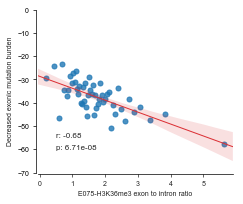

In [11]:
do_plot('crc', 'clusterA', 'E075-H3K36me3', bin_size, False, 'A', (3.5, 3))

### Panel b)

Decrease of exonic mutation burden in MSI-H and glioblastoma bMMRD tumores. H3k36me3 reads coverage computed from colonic mucos (E075)cell and brain angular gyrus (E067).

0.123010188944 0.459325330392


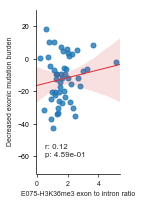

0.0694205598958 0.644804774985


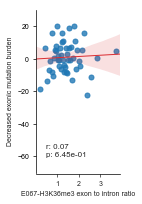

In [12]:
do_plot('crc', 'clusterB', 'E075-H3K36me3', bin_size, False, 'B_crc', (1.5, 3))
do_plot('bMMRD', 'clusterA', 'E067-H3K36me3', bin_size, False, 'B_bMMRD', (1.5, 3))